In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import plotly.express as px
from sklearn.cluster import KMeans

import acquire
import acq
import wrangle_zillow
import wrangle_mall
import explore_zillow
import env

# Acquire data from the customers table in the mall_customers database

In [30]:
df = acq.get_mallcustomer_data()
iris_df = sns.load_dataset("iris")

In [3]:
num_missing = df.isnull().sum(axis=1)
prnt_miss = num_missing / df.shape[1] * 100
rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prnt_miss})\
            .reset_index().groupby(['num_cols_missing', 'percent_cols_missing']).count().reset_index()

In [4]:
rows_missing.columns[-1]

'customer_id'

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


# Split data into train, validate, and test.

In [6]:
# Create train_validate and test datasets
train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
# Create train and validate datsets
train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)

print(f"train -> {train.shape}")
print(f"validate -> {validate.shape}")
print(f"test -> {test.shape}")

target = "spending_score"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]



train -> (120, 4)
validate -> (40, 4)
test -> (40, 4)


In [36]:
# Create train_validate and test datasets
iris_train_validate, iris_test = train_test_split(iris_df, test_size=0.2, random_state=123)
# Create train and validate datsets
iris_train, iris_validate = train_test_split(iris_train_validate, test_size=0.25, random_state=123)

print(f"train -> {iris_train.shape}")
print(f"validate -> {iris_validate.shape}")
print(f"test -> {iris_test.shape}")



train -> (90, 5)
validate -> (30, 5)
test -> (30, 5)


# Scaling

In [ ]:
iris_X = iris_train[iris_train.drop(columns=["species"]).columns.tolist()]

# make, fit, apply:
scaler_iris = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_iris_scaled = pd.DataFrame(
    scaler_iris.fit_transform(iris_X),
    index = iris_X.index,
    columns = iris_X.columns)

In [37]:
X_iris_scaled

,sepal_length,sepal_width,petal_length,petal_width
86,0.647059,0.55,0.649123,0.583333
82,0.382353,0.35,0.508772,0.458333
109,0.794118,0.80,0.894737,1.000000
147,0.588235,0.50,0.736842,0.791667
49,0.147059,0.65,0.070175,0.041667
...,...,...,...,...
78,0.441176,0.45,0.614035,0.583333
55,0.352941,0.40,0.614035,0.500000
125,0.794118,0.60,0.877193,0.708333
22,0.029412,0.80,0.000000,0.041667


In [38]:
fig = px.scatter_3d(X_iris_scaled, x="petal_length", y="petal_width",z="sepal_width",color="sepal_length")
fig.show()

In [8]:
X = train.drop(columns = "gender")

# apply scaling so that my distance based algorithms
# will properly observe the data present
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

In [9]:
fig = px.scatter(X, x="annual_income", y="spending_score",color="age")
fig.show()

In [10]:
fig = px.scatter(X_scaled, x="annual_income", y="spending_score",color="age")
fig.show()

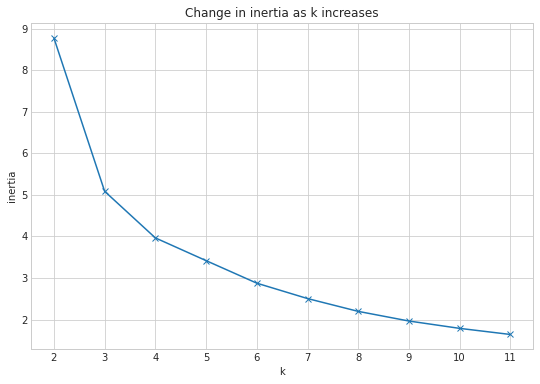

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_iris_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for iris')

3

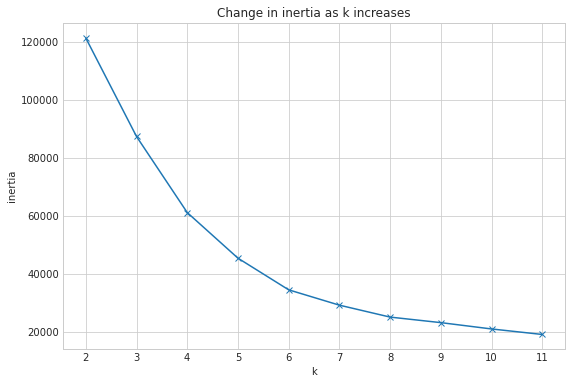

In [11]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for mall (unscaled)')

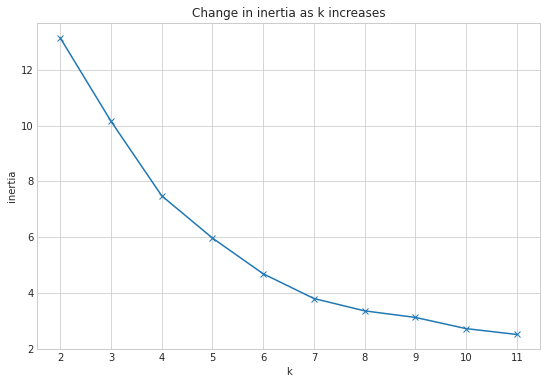

In [12]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for mall (scaled)')

In [57]:
iris_kmeans = KMeans(n_clusters=3)
iris_kmeans.fit(X_iris_scaled)
X_iris_scaled["cluster"] = iris_kmeans.predict(X_iris_scaled)
X_iris_scaled.cluster = X_iris_scaled.cluster.astype("object")
X_iris_scaled

,sepal_length,sepal_width,petal_length,petal_width,cluster
86,0.647059,0.55,0.649123,0.583333,1
82,0.382353,0.35,0.508772,0.458333,2
109,0.794118,0.80,0.894737,1.000000,1
147,0.588235,0.50,0.736842,0.791667,1
49,0.147059,0.65,0.070175,0.041667,0
...,...,...,...,...,...
78,0.441176,0.45,0.614035,0.583333,2
55,0.352941,0.40,0.614035,0.500000,2
125,0.794118,0.60,0.877193,0.708333,1
22,0.029412,0.80,0.000000,0.041667,0


In [13]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
X["cluster"] = kmeans.predict(X)
X

,age,annual_income,spending_score,cluster
customer_id,,,,
64,54,47,59,1
49,29,40,42,1
25,54,28,14,2
137,44,73,7,4
177,58,88,15,4
...,...,...,...,...
176,30,88,86,0
102,49,62,48,1
149,34,78,22,4


In [14]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)
X_scaled

,age,annual_income,spending_score,cluster
customer_id,,,,
64,0.692308,0.262295,0.617021,1
49,0.211538,0.204918,0.436170,4
25,0.692308,0.106557,0.138298,1
137,0.500000,0.475410,0.063830,3
177,0.769231,0.598361,0.148936,3
...,...,...,...,...
176,0.230769,0.598361,0.904255,2
102,0.596154,0.385246,0.500000,1
149,0.307692,0.516393,0.223404,3


In [51]:
X_iris_scaled

,sepal_length,sepal_width,petal_length,petal_width,cluster
86,0.647059,0.55,0.649123,0.583333,2
82,0.382353,0.35,0.508772,0.458333,0
109,0.794118,0.80,0.894737,1.000000,2
147,0.588235,0.50,0.736842,0.791667,2
49,0.147059,0.65,0.070175,0.041667,1
...,...,...,...,...,...
78,0.441176,0.45,0.614035,0.583333,0
55,0.352941,0.40,0.614035,0.500000,0
125,0.794118,0.60,0.877193,0.708333,2
22,0.029412,0.80,0.000000,0.041667,1


In [53]:
fig = px.scatter_3d(X_iris_scaled, x='sepal_length', y='sepal_width', z='petal_width',
              color='petal_length', size='petal_length', size_max=18,
              symbol='cluster', opacity=0.7)


fig.show()

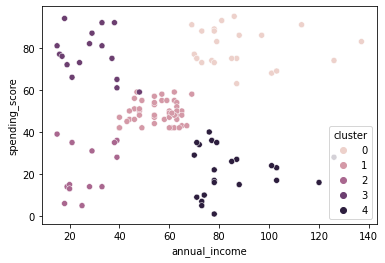

In [27]:
sns.scatterplot(data=X, x="annual_income", y="spending_score",hue="cluster")
plt.show()

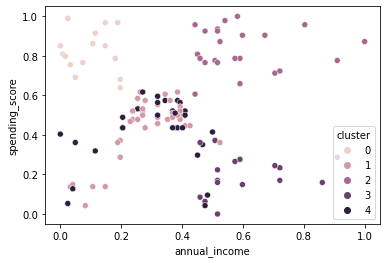

In [28]:
sns.scatterplot(data=X_scaled, x="annual_income", y="spending_score",hue="cluster")
plt.show()

In [49]:
X_iris_scaled

,sepal_length,sepal_width,petal_length,petal_width,cluster
86,0.647059,0.55,0.649123,0.583333,2
82,0.382353,0.35,0.508772,0.458333,0
109,0.794118,0.80,0.894737,1.000000,2
147,0.588235,0.50,0.736842,0.791667,2
49,0.147059,0.65,0.070175,0.041667,1
...,...,...,...,...,...
78,0.441176,0.45,0.614035,0.583333,0
55,0.352941,0.40,0.614035,0.500000,0
125,0.794118,0.60,0.877193,0.708333,2
22,0.029412,0.80,0.000000,0.041667,1


In [56]:
iris_centroids = pd.DataFrame(iris_kmeans.cluster_centers_, columns=X_iris_scaled.columns)
iris_centroids

,sepal_length,sepal_width,petal_length,petal_width,cluster
0,0.369485,0.317188,0.577303,0.526042,1.000000e+00
1,0.150327,0.696296,0.083821,0.066358,2.220446e-16
2,0.649905,0.562903,0.774759,0.763441,2.000000e+00


In [17]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.drop(columns="cluster").columns)
centroids

,age,annual_income,spending_score
0,32.478261,87.304348,80.173913
1,44.956522,55.500000,49.217391
2,46.307692,26.461538,21.923077
3,23.250000,28.375000,77.062500
4,39.954545,84.590909,21.454545


In [18]:
centroids_scaled = pd.DataFrame(kmeans_scaled.cluster_centers_, columns=X_scaled.drop(columns="cluster").columns)
centroids_scaled

,age,annual_income,spending_score
0,0.107692,0.098907,0.821986
1,0.733368,0.288436,0.441921
2,0.284455,0.586407,0.832447
3,0.504808,0.602971,0.201463
4,0.163462,0.305328,0.418313


Text(0.5, 1.0, 'Visualizing Cluster Centers')

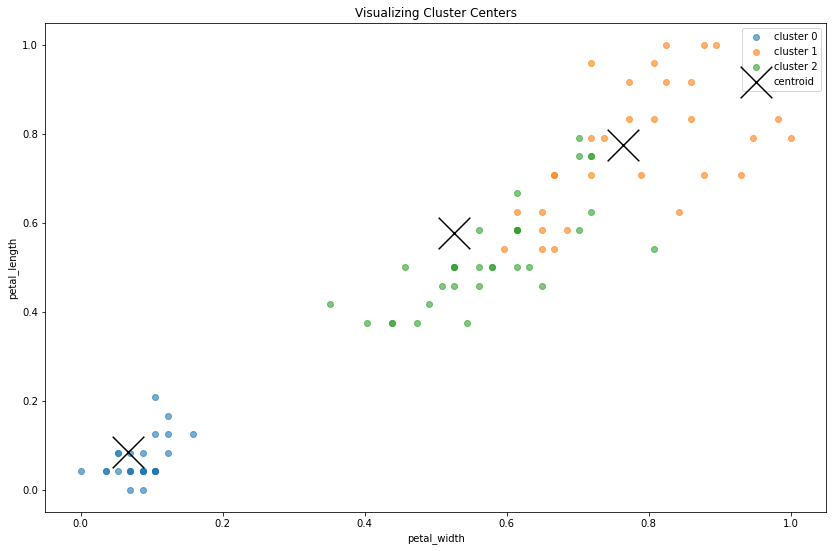

In [61]:

plt.figure(figsize=(14, 9))

for cluster, subset in X_iris_scaled.groupby('cluster'):
    plt.scatter(subset.petal_length, subset.petal_width, label='cluster ' + str(cluster), alpha=.6)

iris_centroids.plot.scatter(y='petal_length', x='petal_width', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('petal_width')
plt.ylabel('petal_length')
plt.title('Visualizing Cluster Centers')

Text(0.5, 1.0, 'Visualizing Cluster Centers')

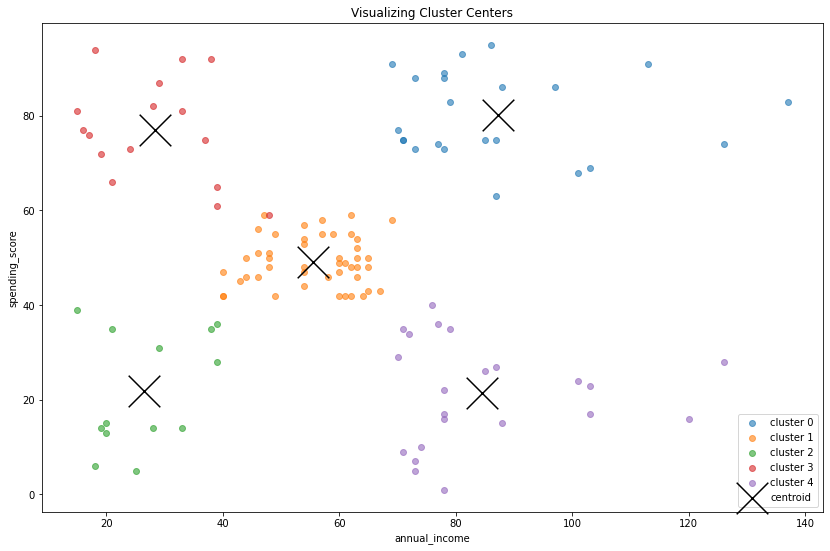

In [20]:

plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    plt.scatter(subset.annual_income, subset.spending_score, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='spending_score', x='annual_income', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('annual_income')
plt.ylabel('spending_score')
plt.title('Visualizing Cluster Centers')

Text(0.5, 1.0, 'Visualizing Cluster Centers')

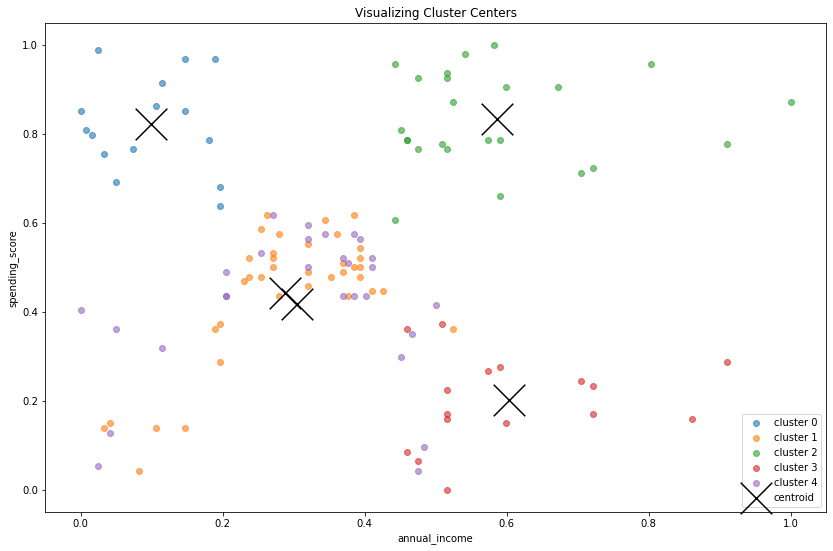

In [22]:

plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('cluster'):
    plt.scatter(subset.annual_income, subset.spending_score, label='cluster ' + str(cluster), alpha=.6)

centroids_scaled.plot.scatter(y='spending_score', x='annual_income', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('annual_income')
plt.ylabel('spending_score')
plt.title('Visualizing Cluster Centers')

# How does scaling impact the results of clustering?

age plays a more equal part in the decison of the cluster